In [1]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [2]:
import os
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

path = "data/text_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 1342848
    })
})

In [3]:
labels = [label for label in dataset['train'].features.keys() if label not in ['text']]
id2label = {i:label for i, label in enumerate(labels)}
label2id = {v:k for k,v in id2label.items()}

print(labels)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


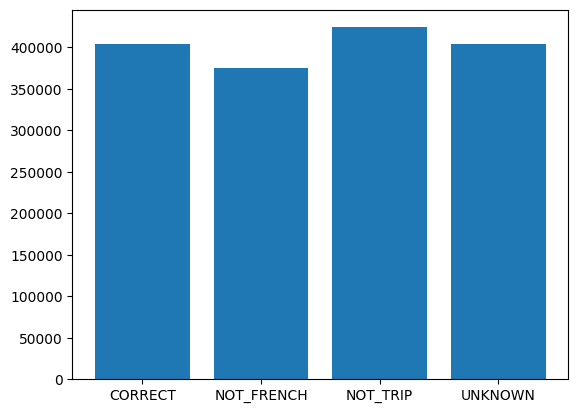

In [4]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset["train"][label]) for label in labels])
plt.show()

In [5]:
# Shuffle train dataset, and pick 20% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
#train_data = train_data.train_test_split(test_size=0.8)['train']

# Split test dataset into 10% validation and 10% test
train_test_valid = train_data.train_test_split(test_size=0.2)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 1074278
    })
    test: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 134285
    })
    valid: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 134285
    })
})

In [6]:
num_main = sum(dataset['train']['CORRECT'])

remove = dataset['train'].filter(lambda example: example['NOT_TRIP'] == 1)
remove_to_keep = remove.shuffle(seed=42).select(range(num_main))

dataset['train'] = dataset['train'].filter(lambda example: example['NOT_TRIP'] == 0)
dataset['train'] = concatenate_datasets([dataset['train'], remove_to_keep])

Filter:   0%|          | 0/1074278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1074278 [00:00<?, ? examples/s]

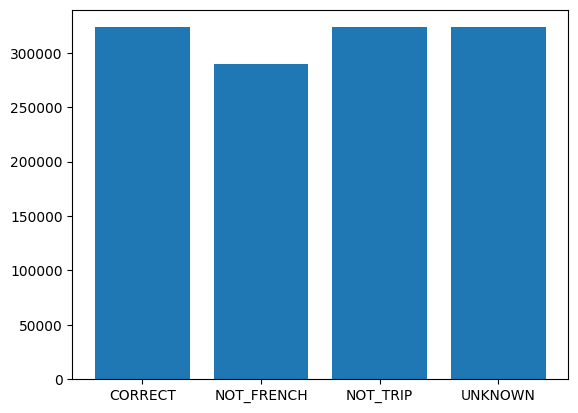

In [7]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset["train"][label]) for label in labels])
plt.show()

In [8]:
model_checkpoint = 'distilbert-base-multilingual-cased'

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]

    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
import numpy as np

encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

example = encoded_dataset['train'][0]
print(example.keys())

In [ ]:
tokenizer.decode(example['input_ids'])

In [ ]:
example['labels']

In [ ]:
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

In [ ]:
encoded_dataset.set_format("torch")

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    model_checkpoint,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

In [ ]:
batch_size = 16
epochs = 5
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    f"models/distilbert-finetuned-text-classification-trip",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [ ]:
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
outputs = model(
    input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), 
    attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0), 
    labels=encoded_dataset['train'][0]['labels'].unsqueeze(0)
)
outputs

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("models/distilbert-finetuned-text-classification-trip")

In [ ]:
train_metrics = trainer.evaluate(encoded_dataset["train"])
validation_metrics = trainer.evaluate(encoded_dataset["valid"])

In [ ]:
text = "Aller de Paris à Marseille"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
predicted_labels

In [ ]:
y_true = encoded_dataset['test']['labels']
y_pred = trainer.predict(encoded_dataset['test']).predictions

# Normalize predictions to 0 and 1
sigmoid = torch.nn.Sigmoid()
y_pred = sigmoid(torch.Tensor(y_pred)).numpy()
y_pred = np.where(y_pred >= 0.5, 1.0, 0.0)

y_true = y_true.numpy()
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_true_binary = np.argmax(y_true, axis=1)
y_pred_binary = np.argmax(y_pred, axis=1)

cm = multilabel_confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(labels), figsize=(20, 5))

for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt='d', ax=ax[i], cmap='Blues')
    ax[i].set_title(label)
    
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
import matplotlib.pyplot as plt

metrics = {
    'eval_accuracy': 'Accuracy',
    'eval_loss': 'Loss',
    'eval_f1': 'F1',
    'eval_roc_auc': 'ROC AUC'
}

for metric, title in metrics.items():
    
    points = []
    
    for epoch in trainer.state.log_history:
        if metric in epoch.keys():
            points.append(epoch[metric])

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(points)
    plt.title(f"{title} per epoch (min / max: {min(points):.2f} / {max(points):.2f})")
    
    plt.subplot(1, 2, 2)
    plt.plot(points)
    plt.ylim(0, 1)
    plt.title(f"{title} per epoch (between 0 and 1)")
    
    plt.show()
    

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], label=f'{label} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend()
plt.show()

In [ ]:
from transformers import pipeline
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
]

for sentence in sentences:
    text_classifier = pipeline("text-classification", model="models/distilbert-finetuned-text-classification-trip")
    outputs = text_classifier(sentence)
    print(outputs)